# **MNIST-1D**: Observing deep double descent

This notebook investigates double descent as described in section 8.4 of the ["Understanding Deep Learning"](https://udlbook.github.io/udlbook/) textbook.

The deep double descent phenomenon was [originally described here](https://arxiv.org/abs/1812.11118) and later extended to modern architectures and large datasets in an [OpenAI research project](https://openai.com/blog/deep-double-descent/).

This case study is meant to show the convenience and computational savings of working with the low-dimensional MNIST-1D dataset. You can find more details at https://github.com/greydanus/mnist1d.

In [1]:
!python -m pip install git+https://github.com/greydanus/mnist1d.git@master

# Download repo directly (gives access to notebooks/models.py and notebooks/train.py)
!git clone https://github.com/greydanus/mnist1d

  Cloning https://github.com/greydanus/mnist1d.git (to revision master) to /tmp/pip-req-build-15yo7ijy
  Running command git clone --filter=blob:none --quiet https://github.com/greydanus/mnist1d.git /tmp/pip-req-build-15yo7ijy
  Resolved https://github.com/greydanus/mnist1d.git to commit ad53e36d4c2d74174fd90b68d1284f024d286acb
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
fatal: destination path 'mnist1d' already exists and is not an empty directory.


In [2]:
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
import mnist1d
import random, os
random.seed(0)

# Try attaching to GPU -- Use "Change Runtime Type to change to GPUT"
DEVICE = str(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
print('Using:', DEVICE)

plt.style.use('https://github.com/greydanus/mnist1d/raw/master/notebooks/mpl_style.txt')

Using: cuda


## Only run this if you're in Google Colab

In [3]:
if True:
    # Only run this in Colab
    from google.colab import drive
    drive.mount('/content/gdrive')
    project_dir = "/content/gdrive/My Drive/Research/mnist1d/"
else:
    project_dir = './'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Set up hyperparameters

In [4]:
args = mnist1d.data.get_dataset_args()
args.num_samples = 8000
args.train_split = 0.5
args.corr_noise_scale = 0.25
args.iid_noise_scale=2e-2
data = mnist1d.data.get_dataset(args, path='./mnist1d_data.pkl', download=False, regenerate=True)

# Add 15% noise to training labels
for c_y in range(len(data['y'])):
    random_number = random.random()
    if random_number < 0.15 :
        random_int = int(random.random() * 10)
        data['y'][c_y] = random_int

# The training and test input and outputs are in
# data['x'], data['y'], data['x_test'], and data['y_test']
print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Length of each example: {}".format(data['x'].shape[-1]))

Did or could not load data from ./mnist1d_data.pkl. Rebuilding dataset...
Examples in training set: 4000
Examples in test set: 4000
Length of each example: 40


In [5]:
# Initialize the parameters with He initialization
def weights_init(layer_in):
  if isinstance(layer_in, nn.Linear):
    nn.init.kaiming_uniform_(layer_in.weight)
    layer_in.bias.data.fill_(0.0)

# Return an initialized model with two hidden layers and n_hidden hidden units at each
def get_model(n_hidden):

  D_i = 40    # Input dimensions
  D_k = n_hidden   # Hidden dimensions
  D_o = 10    # Output dimensions

  # Define a model with two hidden layers of size 100
  # And ReLU activations between them
  model = nn.Sequential(
  nn.Linear(D_i, D_k),
  nn.ReLU(),
  nn.Linear(D_k, D_k),
  nn.ReLU(),
  nn.Linear(D_k, D_o))

  # Call the function you just defined
  model.apply(weights_init)

  # Return the model
  return model ;

In [6]:
def fit_model(model, data):

  # choose cross entropy loss function (equation 5.24)
  loss_function = torch.nn.CrossEntropyLoss()
  # construct SGD optimizer and initialize learning rate and momentum
  # optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum=0.9)


  # create 100 dummy data points and store in data loader class
  x_train = torch.tensor(data['x'].astype('float32'))
  y_train = torch.tensor(data['y'].transpose().astype('long'))
  x_test= torch.tensor(data['x_test'].astype('float32'))
  y_test = torch.tensor(data['y_test'].astype('long'))

  # load the data into a class that creates the batches
  data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size=100, shuffle=True, worker_init_fn=np.random.seed(1))

  # loop over the dataset n_epoch times
  n_epoch = 1000

  for epoch in range(n_epoch):
    # loop over batches
    for i, batch in enumerate(data_loader):
      # retrieve inputs and labels for this batch
      x_batch, y_batch = batch
      # zero the parameter gradients
      optimizer.zero_grad()
      # forward pass -- calculate model output
      pred = model(x_batch)
      # compute the loss
      loss = loss_function(pred, y_batch)
      # backward pass
      loss.backward()
      # SGD update
      optimizer.step()

    # Run whole dataset to get statistics -- normally wouldn't do this
    pred_train = model(x_train)
    pred_test = model(x_test)
    _, predicted_train_class = torch.max(pred_train.data, 1)
    _, predicted_test_class = torch.max(pred_test.data, 1)
    errors_train = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
    errors_test= 100 - 100 * (predicted_test_class == y_test).float().sum() / len(y_test)
    losses_train = loss_function(pred_train, y_train).item()
    losses_test= loss_function(pred_test, y_test).item()
    if epoch%100 ==0 :
      print(f'Epoch {epoch:5d}, train loss {losses_train:.6f}, train error {errors_train:3.2f},  test loss {losses_test:.6f}, test error {errors_test:3.2f}')

  return errors_train, errors_test


## The following code produces the double descent curve by training the model with different numbers of hidden units and plotting the test error.

In [7]:
# This code will take a while (~30 mins on GPU) to run!  Go and make a cup of coffee!

hidden_variables = np.array([2,4,6,8,10,14,18,22,26,30,35,40,45,50,55,60,70,80,90,100,120,140,160,180,200,250,300,400]) ;
errors_train_all = np.zeros_like(hidden_variables)
errors_test_all = np.zeros_like(hidden_variables)

# For each hidden variable size
for c_hidden in range(len(hidden_variables)):
    print(f'Training model with {hidden_variables[c_hidden]:3d} hidden variables')
    # Get a model
    model = get_model(hidden_variables[c_hidden]) ;
    # Train the model
    errors_train, errors_test = fit_model(model, data)
    # Store the results
    errors_train_all[c_hidden] = errors_train
    errors_test_all[c_hidden]= errors_test

Training model with   2 hidden variables
Epoch     0, train loss 2.277798, train error 85.95,  test loss 2.278397, test error 86.47
Epoch   100, train loss 1.929422, train error 73.53,  test loss 1.759784, test error 70.10
Epoch   200, train loss 1.911519, train error 70.95,  test loss 1.762149, test error 69.47
Epoch   300, train loss 1.904752, train error 70.93,  test loss 1.750811, test error 67.88
Epoch   400, train loss 1.902335, train error 72.22,  test loss 1.733160, test error 68.28
Epoch   500, train loss 1.899587, train error 71.32,  test loss 1.730040, test error 67.85
Epoch   600, train loss 1.898971, train error 70.25,  test loss 1.748773, test error 68.62
Epoch   700, train loss 1.901459, train error 70.97,  test loss 1.744638, test error 68.70
Epoch   800, train loss 1.907022, train error 71.90,  test loss 1.726579, test error 68.60
Epoch   900, train loss 1.899073, train error 71.30,  test loss 1.728388, test error 68.20
Training model with   4 hidden variables
Epoch   

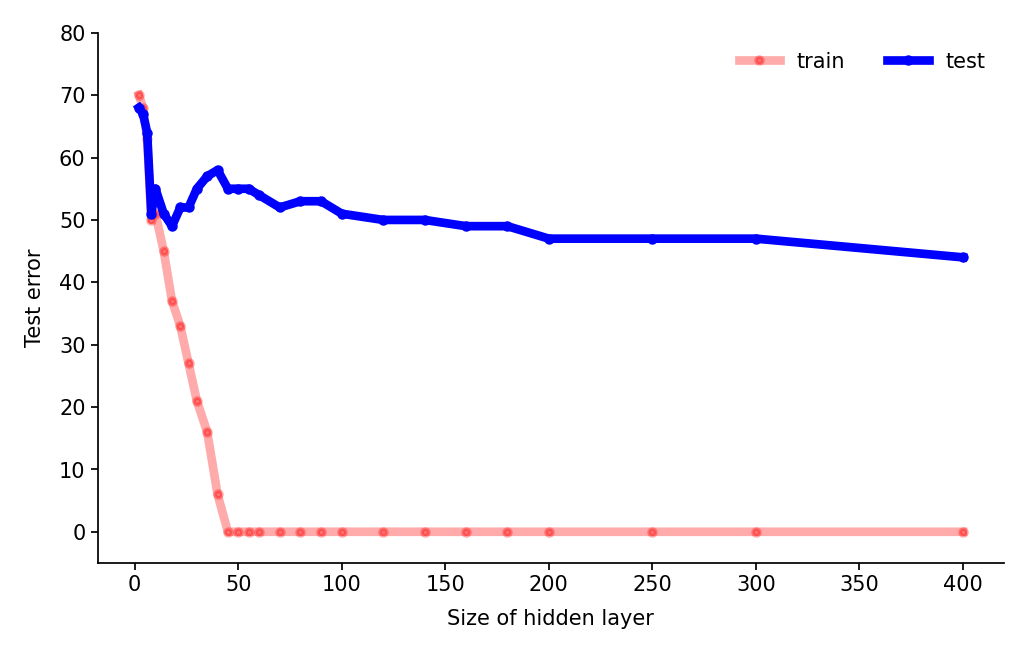

In [8]:
fig = plt.figure(dpi=250, figsize=[4,2.5])
plt.plot(hidden_variables, errors_train_all,'r.-', label='train', alpha=0.33, linewidth=2.5)
plt.plot(hidden_variables, errors_test_all,'b.-', label='test', linewidth=2.5)
plt.ylim(-5,80);
plt.xlabel('Size of hidden layer'); plt.ylabel('Test error')
plt.legend(ncols=2)
plt.show()

os.makedirs(project_dir + 'figures/', exist_ok=True)
fig.savefig(project_dir + 'figures/deep_double_descent.png')
fig.savefig(project_dir + 'figures/deep_double_descent.pdf')